##1. Setup & Load Model/Data

In [21]:
# Step 1: Imports and File Loading

import xgboost as xgb
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Load Model
xgb_model = xgb.Booster()
xgb_model.load_model("/content/drive/MyDrive/healthcarefraud_detection/models/xgboost_fraud_model.json")

# 1.2 Load Validation Data
X_val = pd.read_parquet("/content/drive/MyDrive/healthcarefraud_detection/data/processed/xgb_val_features.parquet")
y_val = pd.read_parquet("/content/drive/MyDrive/healthcarefraud_detection/data/processed/xgb_val_labels.parquet").squeeze()  # to get as Series

print("Model and validation data loaded.")
print("Validation set shape:", X_val.shape)
print("Label shape:", y_val.shape)


Model and validation data loaded.
Validation set shape: (1082, 28)
Label shape: (1082,)


##Step 2: SHAP Explainer Setup

In [22]:
# Step 2: Initialize SHAP Explainer for XGBoost
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

print("SHAP values computed. Shape:", np.array(shap_values).shape)


SHAP values computed. Shape: (1082, 28)


##Step 3: Global Feature Importance (SHAP Summary Plot)

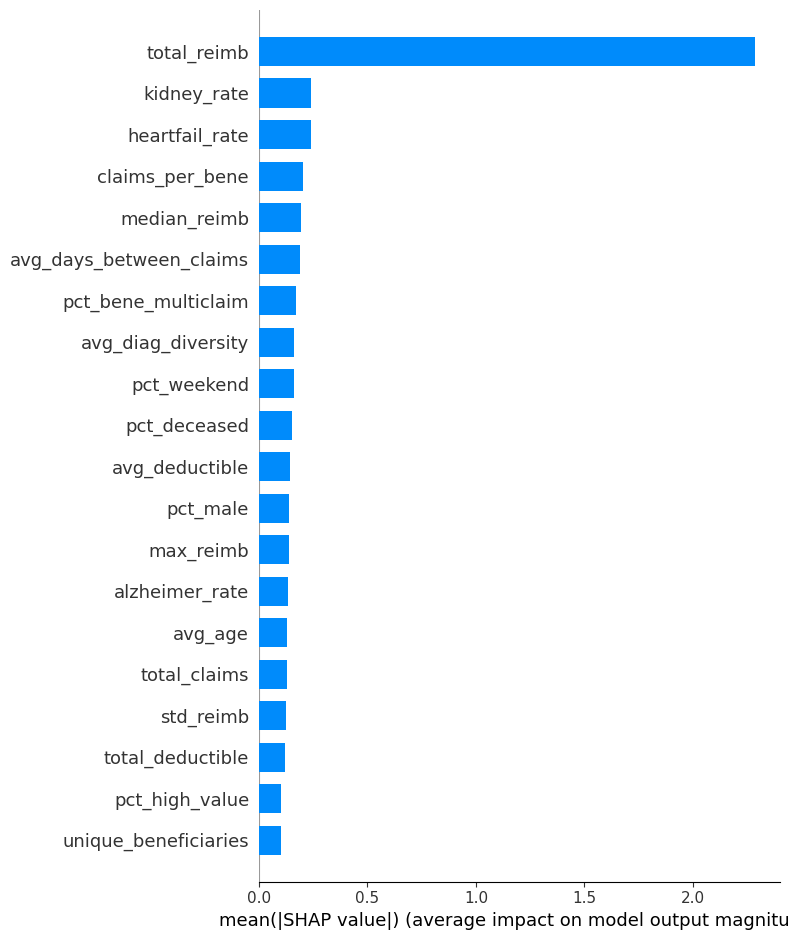

In [23]:
# Step 3: SHAP Summary Plot (Global Feature Importance)
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/plots/shap_summary_bar.png')
shap.summary_plot(shap_values, X_val, plot_type="bar", show=True)


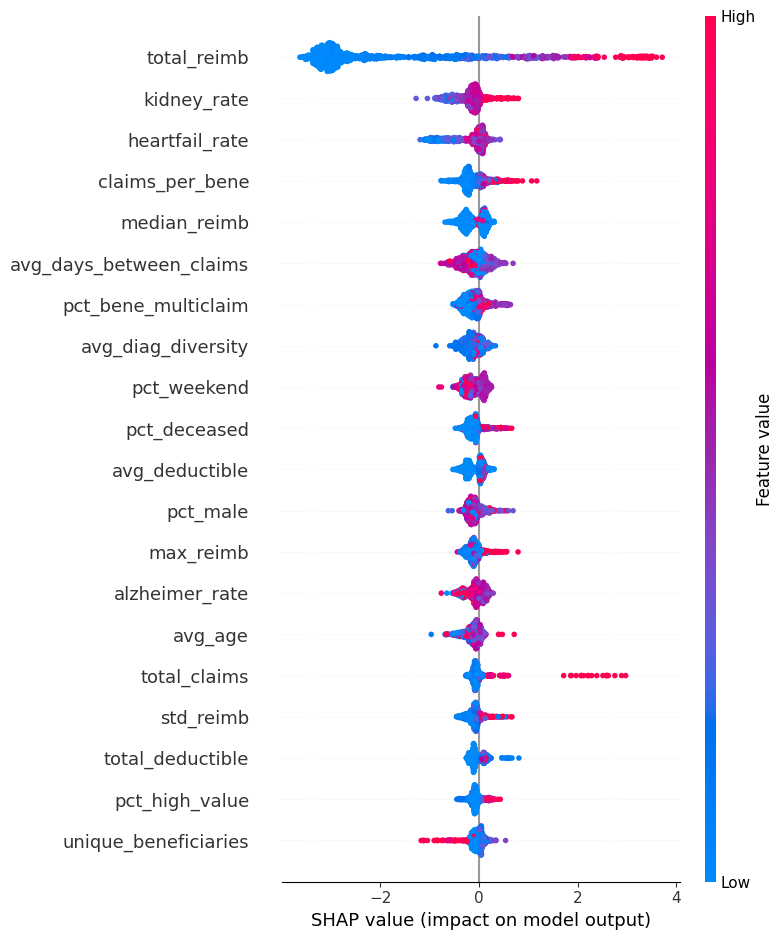

<Figure size 640x480 with 0 Axes>

In [5]:
shap.summary_plot(shap_values, X_val, show=True)
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/shap_beeswarm.png')


In [6]:
plt.savefig("/content/drive/MyDrive/healthcarefraud_detection/data/plots/shap_summary_bar.png")


<Figure size 640x480 with 0 Axes>

# SHAP Model Interpretability: Global Insights

## Overview

To understand *why* the XGBoost model predicts certain providers as fraudulent, we applied SHAP (SHapley Additive exPlanations) analysis to the validation set.

---

## Key Insights

- **total_reimb** (total reimbursement amount) is the most impactful feature in predicting fraud. Providers with unusually high total reimbursement are flagged as higher risk.
- **kidney_rate** and **heartfail_rate** (rates of patients with chronic kidney disease and heart failure) are also significant drivers, possibly reflecting patient mix manipulation or upcoding.
- **claims_per_bene** (claims per beneficiary) and **median_reimb** are strong secondary factors, highlighting abnormal billing patterns.

---

## Visual Explanation

- The **SHAP bar plot** ranks features by their overall contribution to fraud predictions.
- The **SHAP beeswarm plot** illustrates, for each feature, whether high (blue) or low (pink) values push the prediction toward fraud or non-fraud. For example:
    - **Higher total_reimb (blue, right) strongly increases fraud risk.**
    - **Higher kidney_rate/heartfail_rate** also tend to increase risk.
    - Some features (e.g., avg_diag_diversity, pct_weekend) have subtler, more distributed effects.

---

## Business Interpretation

- The model is using both financial (reimbursement) and patient population clues to detect suspicious providers.
- Results support audit focus on providers with extreme total reimbursement, high chronic disease rates, and unusual claim frequencies.

---

##Step 5: Per-Provider (Local) SHAP Explanations

In [6]:
# Find a provider that was predicted as fraud (label 1)
y_proba = xgb_model.predict(xgb.DMatrix(X_val))  # probabilities
y_pred = (y_proba > 0.5).astype(int)

fraud_indices = np.where(y_pred == 1)[0]
if len(fraud_indices) == 0:
    print("No fraud predictions in this set!")
else:
    i = fraud_indices[0]  # Take the first one
    print(f"Provider index {i} was predicted as fraud")


Provider index 13 was predicted as fraud


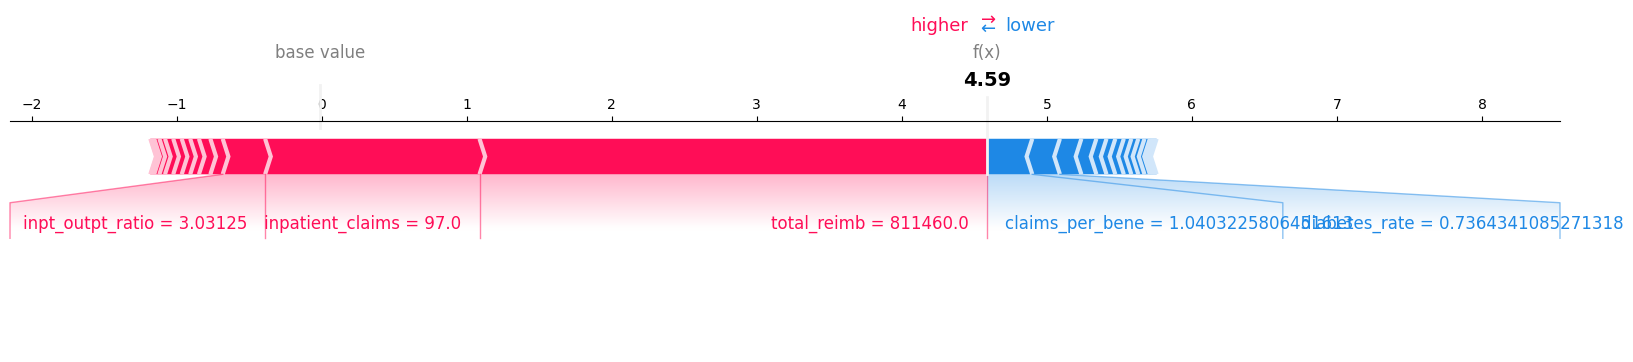

<Figure size 640x480 with 0 Axes>

In [10]:
# Single sample SHAP explanation (force plot)
shap.initjs()  # For notebook visual
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_val.iloc[i, :],
    matplotlib=True  # Use True for static images in Colab
)
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/shap_force_provider_13.png')


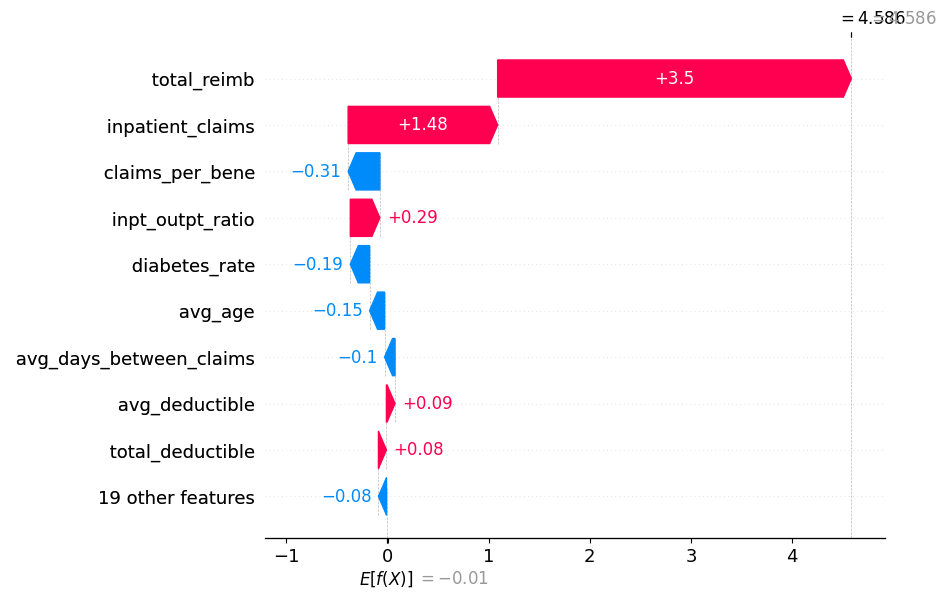

In [11]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_values[i], X_val.iloc[i, :]
)
X_val.iloc[[i]].to_csv('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/provider13_features.csv')


In [10]:
print("Provider feature values:\n", X_val.iloc[i, :])


Provider feature values:
 total_claims                  129.000000
inpatient_claims               97.000000
outpatient_claims              32.000000
total_reimb                811460.000000
avg_reimb                    6290.387597
median_reimb                 5000.000000
std_reimb                    7207.595972
max_reimb                   57000.000000
total_deductible           102868.000000
avg_deductible                797.426357
inpt_outpt_ratio                3.031250
claims_per_bene                 1.040323
unique_beneficiaries          124.000000
avg_age                        74.558140
pct_deceased                    0.007752
pct_male                        0.457364
race_diversity                  4.000000
alzheimer_rate                  0.465116
heartfail_rate                  0.720930
kidney_rate                     0.565891
diabetes_rate                   0.736434
pct_bene_multiclaim             0.040323
avg_diag_diversity              6.844961
avg_proc_diversity             

# Local Model Interpretability: Per-Provider SHAP Analysis

## Objective

To understand the specific drivers behind the model’s fraud prediction for an individual provider, we applied SHAP local explanation to a sample flagged as fraud by the XGBoost model.

---

## Case Example: Provider Index 13

- **Model prediction:** Fraud (label = 1)
- **Predicted probability:** 4.59 (log-odds before sigmoid; high value indicates strong confidence in fraud class)

### **Top Feature Contributions (SHAP Force/Waterfall Plots)**

| Feature             | Value         | SHAP Impact | Interpretation                                           |
|---------------------|--------------|-------------|---------------------------------------------------------|
| `total_reimb`       | 811,460      | +3.5        | Exceptionally high total reimbursement; major red flag   |
| `inpatient_claims`  | 97           | +1.5        | Very high number of inpatient claims                     |
| `inpt_outpt_ratio`  | 3.03         | +0.29       | More inpatient vs. outpatient claims than typical        |
| `claims_per_bene`   | 1.04         | -0.31       | Slightly lowers fraud risk (within normal range)         |
| `diabetes_rate`     | 0.74         | -0.19       | Patient mix: high but did not push fraud risk up         |
| (Other features)    | ...          | ...         | Smaller impact                                          |

### **Summary of Key Drivers**

- The **overwhelming reason** for this provider’s fraud prediction is the very high total reimbursement, supported by an unusually high number of inpatient claims and a skewed inpatient/outpatient ratio.
- Some features (e.g., claims per beneficiary, diabetes rate) slightly mitigated the risk, but the dominant financial patterns led to a high fraud score.

---

## Provider Feature Snapshot

| Feature               | Value        |
|-----------------------|-------------|
| total_claims          | 129         |
| inpatient_claims      | 97          |
| outpatient_claims     | 32          |
| total_reimb           | 811,460     |
| avg_reimb             | 6,290       |
| median_reimb          | 5,000       |
| ...                   | ...         |

*(See full feature list in notebook for auditability.)*

---

## Business Interpretation

- **Actionable insight:**  
  The model flags this provider due to unusually high reimbursement and claim volume. Such patterns are classic fraud indicators in healthcare, suggesting possible upcoding, phantom billing, or patient record manipulation.
- **Transparency:**  
  SHAP makes it clear *why* this provider was flagged, supporting fair and explainable decision-making in audits or compliance review.

---

## Visual Explanation

- **Force plot**: Shows which features push the prediction toward or away from fraud.
- **Waterfall plot**: Quantifies the individual impact of each feature on the final prediction.

---

> *This per-provider SHAP analysis delivers actionable, transparent insight for investigators and stakeholders, building trust and supporting defensible fraud detection in healthcare.*


In [14]:
import numpy as np
np.save('/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/shap_values.npy', shap_values)

In [18]:
import pandas as pd
importance = np.abs(shap_values).mean(axis=0)
feature_names = X_val.columns.tolist()

shap_summary_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': importance})
shap_summary_df.sort_values('mean_abs_shap', ascending=False).to_csv(
    '/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/shap_feature_importance.csv', index=False
)
